In [2]:
import os
import random
import torch
import numpy as np
import cv2
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, RandomHorizontalFlip, RandomCrop, RandomRotation
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image

In [3]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [5]:
class ColorectalCancerDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        img = self.img_paths[idx]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)  # Convert the NumPy array to a PIL Image
        img = self.transform(img)
        label = self.labels[idx]
        return img, label

    def __len__(self):
        return len(self.img_paths)

In [6]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('colorectal_histology', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/2.0.0.incomplete8RHHG2/colorectal_histology-train.tfr…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [7]:
# Set seed for reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define data augmentation transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),  # Add this line
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),  # Add this line
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Get the list of classes
classes = info.features['label'].names

# Get the image paths and corresponding labels
img_paths, labels = [], []
for example in dataset['train']:
    img_paths.append(example['image'].numpy())
    labels.append(example['label'].numpy())

# Split the data into train, validation, and test sets (70% train, 15% validation, 15% test)
train_img_paths, temp_img_paths, train_labels, temp_labels = train_test_split(
    img_paths, labels, test_size=0.3, stratify=labels, random_state=42
)
val_img_paths, test_img_paths, val_labels, test_labels = train_test_split(
    temp_img_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

train_dataset = ColorectalCancerDataset(train_img_paths, train_labels, transform=train_transform)
val_dataset = ColorectalCancerDataset(val_img_paths, val_labels, transform=test_transform)
test_dataset = ColorectalCancerDataset(test_img_paths, test_labels, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

densenet = models.densenet121(pretrained=True)
num_classes = len(set(train_labels))
densenet.classifier = nn.Linear(densenet.classifier.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

num_epochs = 50

accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train the model
    densenet.train()
    train_loss = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = densenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Train Loss: {train_loss}")

    # Validate the model
    densenet.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = densenet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct / total
    accuracies.append(val_acc)
    if val_acc >= max(accuracies):
        torch.save(densenet.state_dict(), "best_model.pt")
    print(f"Val Loss: {val_loss}, Val Acc: {val_acc}")

print("Average accuracy: ", sum(accuracies) / len(accuracies))




/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 181MB/s]


Epoch 1/50


100%|██████████| 110/110 [00:26<00:00,  4.09it/s]


Train Loss: 0.7539546929977157
Val Loss: 0.2693124522144596, Val Acc: 0.912
Epoch 2/50


100%|██████████| 110/110 [00:18<00:00,  5.79it/s]


Train Loss: 0.3014872621406208
Val Loss: 0.1991745981698235, Val Acc: 0.936
Epoch 3/50


100%|██████████| 110/110 [00:19<00:00,  5.76it/s]


Train Loss: 0.21954460299827835
Val Loss: 0.15869892423506826, Val Acc: 0.9386666666666666
Epoch 4/50


100%|██████████| 110/110 [00:19<00:00,  5.78it/s]


Train Loss: 0.20345295884392478
Val Loss: 0.15417792539422712, Val Acc: 0.96
Epoch 5/50


100%|██████████| 110/110 [00:19<00:00,  5.67it/s]


Train Loss: 0.16580319407988678
Val Loss: 0.1388076291574786, Val Acc: 0.9533333333333334
Epoch 6/50


100%|██████████| 110/110 [00:19<00:00,  5.71it/s]


Train Loss: 0.12503285667097028
Val Loss: 0.12788938245891282, Val Acc: 0.9533333333333334
Epoch 7/50


100%|██████████| 110/110 [00:19<00:00,  5.70it/s]


Train Loss: 0.10611119262281467
Val Loss: 0.11430707375984639, Val Acc: 0.9613333333333334
Epoch 8/50


100%|██████████| 110/110 [00:19<00:00,  5.71it/s]


Train Loss: 0.09091440658508376
Val Loss: 0.11880143219605088, Val Acc: 0.9573333333333334
Epoch 9/50


100%|██████████| 110/110 [00:19<00:00,  5.68it/s]


Train Loss: 0.08798886489292437
Val Loss: 0.11536738707218319, Val Acc: 0.9533333333333334
Epoch 10/50


100%|██████████| 110/110 [00:19<00:00,  5.65it/s]


Train Loss: 0.06644203842363575
Val Loss: 0.11319069585685308, Val Acc: 0.9586666666666667
Epoch 11/50


100%|██████████| 110/110 [00:19<00:00,  5.67it/s]


Train Loss: 0.05787747772410512
Val Loss: 0.12411638900327186, Val Acc: 0.9546666666666667
Epoch 12/50


100%|██████████| 110/110 [00:19<00:00,  5.65it/s]


Train Loss: 0.05054045101543042
Val Loss: 0.10653291085812573, Val Acc: 0.9586666666666667
Epoch 13/50


100%|██████████| 110/110 [00:19<00:00,  5.62it/s]


Train Loss: 0.04537225135559724
Val Loss: 0.10523766364591818, Val Acc: 0.96
Epoch 14/50


100%|██████████| 110/110 [00:19<00:00,  5.63it/s]


Train Loss: 0.038218345454978674
Val Loss: 0.1089834727269287, Val Acc: 0.96
Epoch 15/50


100%|██████████| 110/110 [00:19<00:00,  5.66it/s]


Train Loss: 0.03460195226361975
Val Loss: 0.10883035782414179, Val Acc: 0.9626666666666667
Epoch 16/50


100%|██████████| 110/110 [00:19<00:00,  5.63it/s]


Train Loss: 0.028701253730634396
Val Loss: 0.09351513491128571, Val Acc: 0.972
Epoch 17/50


100%|██████████| 110/110 [00:19<00:00,  5.61it/s]


Train Loss: 0.029296368165788324
Val Loss: 0.09726275423599873, Val Acc: 0.9653333333333334
Epoch 18/50


100%|██████████| 110/110 [00:19<00:00,  5.62it/s]


Train Loss: 0.026366360872899265
Val Loss: 0.09909799897286575, Val Acc: 0.9626666666666667
Epoch 19/50


100%|██████████| 110/110 [00:19<00:00,  5.64it/s]


Train Loss: 0.01727437586946921
Val Loss: 0.09160934779598999, Val Acc: 0.968
Epoch 20/50


100%|██████████| 110/110 [00:19<00:00,  5.60it/s]


Train Loss: 0.021094610294411807
Val Loss: 0.10356010488855343, Val Acc: 0.9746666666666667
Epoch 21/50


100%|██████████| 110/110 [00:19<00:00,  5.61it/s]


Train Loss: 0.015144044676774436
Val Loss: 0.09826861942807834, Val Acc: 0.968
Epoch 22/50


100%|██████████| 110/110 [00:19<00:00,  5.62it/s]


Train Loss: 0.021790117548185994
Val Loss: 0.09618181905049521, Val Acc: 0.964
Epoch 23/50


100%|██████████| 110/110 [00:19<00:00,  5.62it/s]


Train Loss: 0.01978145904246379
Val Loss: 0.10711284922823931, Val Acc: 0.964
Epoch 24/50


100%|██████████| 110/110 [00:19<00:00,  5.61it/s]


Train Loss: 0.01533334316495298
Val Loss: 0.10097470493443932, Val Acc: 0.964
Epoch 25/50


100%|██████████| 110/110 [00:19<00:00,  5.57it/s]


Train Loss: 0.015937241331398996
Val Loss: 0.09464835205775064, Val Acc: 0.9666666666666667
Epoch 26/50


100%|██████████| 110/110 [00:19<00:00,  5.59it/s]


Train Loss: 0.01827519234714352
Val Loss: 0.11746856573154218, Val Acc: 0.9613333333333334
Epoch 27/50


100%|██████████| 110/110 [00:19<00:00,  5.55it/s]


Train Loss: 0.017715927702110175
Val Loss: 0.08375639547981943, Val Acc: 0.9653333333333334
Epoch 28/50


100%|██████████| 110/110 [00:19<00:00,  5.55it/s]


Train Loss: 0.01454870073463429
Val Loss: 0.09824387534657338, Val Acc: 0.968
Epoch 29/50


100%|██████████| 110/110 [00:19<00:00,  5.58it/s]


Train Loss: 0.019630561395950447
Val Loss: 0.0998811376048252, Val Acc: 0.968
Epoch 30/50


100%|██████████| 110/110 [00:19<00:00,  5.60it/s]


Train Loss: 0.010499459457456726
Val Loss: 0.0951242228281141, Val Acc: 0.9666666666666667
Epoch 31/50


100%|██████████| 110/110 [00:19<00:00,  5.62it/s]


Train Loss: 0.011176251169209454
Val Loss: 0.07166912662796676, Val Acc: 0.972
Epoch 32/50


100%|██████████| 110/110 [00:19<00:00,  5.56it/s]


Train Loss: 0.016503625469472767
Val Loss: 0.0965345224297683, Val Acc: 0.968
Epoch 33/50


100%|██████████| 110/110 [00:19<00:00,  5.58it/s]


Train Loss: 0.011766688359520314
Val Loss: 0.08828330257286628, Val Acc: 0.9733333333333334
Epoch 34/50


100%|██████████| 110/110 [00:19<00:00,  5.61it/s]


Train Loss: 0.01160004741792694
Val Loss: 0.09136839202255942, Val Acc: 0.9626666666666667
Epoch 35/50


100%|██████████| 110/110 [00:19<00:00,  5.60it/s]


Train Loss: 0.009277111024130136
Val Loss: 0.08795298282348085, Val Acc: 0.968
Epoch 36/50


100%|██████████| 110/110 [00:19<00:00,  5.59it/s]


Train Loss: 0.011086859324925834
Val Loss: 0.10030329079503038, Val Acc: 0.9626666666666667
Epoch 37/50


100%|██████████| 110/110 [00:19<00:00,  5.58it/s]


Train Loss: 0.008785395888050765
Val Loss: 0.07900261980830692, Val Acc: 0.9706666666666667
Epoch 38/50


100%|██████████| 110/110 [00:19<00:00,  5.62it/s]


Train Loss: 0.006902553241393021
Val Loss: 0.09351423516151651, Val Acc: 0.964
Epoch 39/50


100%|██████████| 110/110 [00:19<00:00,  5.59it/s]


Train Loss: 0.007485914247941268
Val Loss: 0.09332955495726007, Val Acc: 0.9626666666666667
Epoch 40/50


100%|██████████| 110/110 [00:19<00:00,  5.58it/s]


Train Loss: 0.006758564066364091
Val Loss: 0.09148346903627196, Val Acc: 0.972
Epoch 41/50


100%|██████████| 110/110 [00:19<00:00,  5.57it/s]


Train Loss: 0.006502992200363555
Val Loss: 0.08886450330949931, Val Acc: 0.9666666666666667
Epoch 42/50


100%|██████████| 110/110 [00:19<00:00,  5.60it/s]


Train Loss: 0.004688427873770706
Val Loss: 0.0828024564543739, Val Acc: 0.9706666666666667
Epoch 43/50


100%|██████████| 110/110 [00:19<00:00,  5.58it/s]


Train Loss: 0.004126503104502758
Val Loss: 0.07625001354123621, Val Acc: 0.972
Epoch 44/50


100%|██████████| 110/110 [00:19<00:00,  5.59it/s]


Train Loss: 0.0053799073791279545
Val Loss: 0.07700351474341005, Val Acc: 0.9706666666666667
Epoch 45/50


100%|██████████| 110/110 [00:19<00:00,  5.55it/s]


Train Loss: 0.005881775059705515
Val Loss: 0.08548530677459591, Val Acc: 0.9706666666666667
Epoch 46/50


100%|██████████| 110/110 [00:19<00:00,  5.56it/s]


Train Loss: 0.004373522979122671
Val Loss: 0.08366350748959424, Val Acc: 0.968
Epoch 47/50


100%|██████████| 110/110 [00:19<00:00,  5.58it/s]


Train Loss: 0.005543828027359929
Val Loss: 0.08079764342134392, Val Acc: 0.9693333333333334
Epoch 48/50


100%|██████████| 110/110 [00:19<00:00,  5.57it/s]


Train Loss: 0.00776854294129986
Val Loss: 0.07892559611354955, Val Acc: 0.968
Epoch 49/50


100%|██████████| 110/110 [00:19<00:00,  5.58it/s]


Train Loss: 0.006003689920312767
Val Loss: 0.09897418570471928, Val Acc: 0.9666666666666667
Epoch 50/50


100%|██████████| 110/110 [00:19<00:00,  5.61it/s]


Train Loss: 0.0050687375440082345
Val Loss: 0.09484870394226164, Val Acc: 0.964
Average accuracy:  0.9628266666666664


In [8]:
# Test the model
densenet.load_state_dict(torch.load("best_model.pt"))  # Load the best model
densenet.eval()

all_outputs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = densenet(inputs)
        _, predicted = outputs.max(1)
        all_outputs.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_outputs)
test_precision = precision_score(all_labels, all_outputs, average='weighted')
test_recall = recall_score(all_labels, all_outputs, average='weighted')
test_f1 = f1_score(all_labels, all_outputs, average='weighted')

print("Test Accuracy: {:.4f}".format(test_accuracy))
print("Test Precision: {:.4f}".format(test_precision))
print("Test Recall: {:.4f}".format(test_recall))
print("Test F1-score: {:.4f}".format(test_f1))

Test Accuracy: 0.9520
Test Precision: 0.9526
Test Recall: 0.9520
Test F1-score: 0.9519


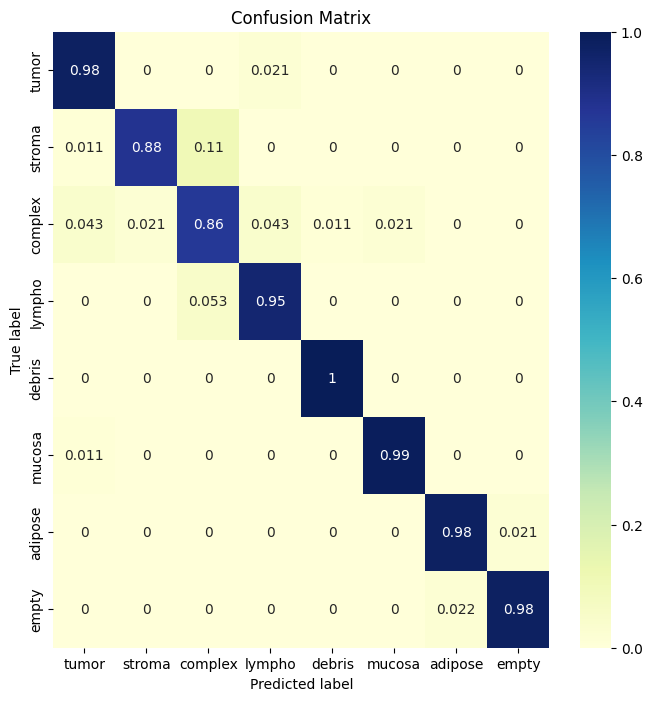

In [9]:
# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_outputs)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualize the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm_normalized, annot=True, cmap="YlGnBu", xticklabels=classes, yticklabels=classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
